#MODELO DE PREDICCIÓN DE VENTAS

##Importación de paquetes y carga de datos

In [1]:
#Importación de paquetes
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import max_error, r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import GridSearchCV #busqueda de hiperparámetros

In [87]:
#Carga de datos
data=pd.read_csv('data2.csv')
data.head()

,Unnamed: 0.1,Unnamed: 0,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,...,A-17-DIF_CAMBIO_23_diff,A-17-DIF_CAMBIO_12_diff,A-20-IMPUESTOS_23_diff,A-20-IMPUESTOS_12_diff,Subvencion,ALTO_CRECIMIENTO_CALCU,GACELA_CALCU,MODELO_CALCU,Inicio Actividad,ULT_ACTOMERCANTIL_Y
0,0,0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,Microempresa,Viva,0.0,0.0,...,0.0,0.0,inf,0.000000,1.0,0.0,0.0,1.0,2016.0,2020.0
1,1,1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,Microempresa,Viva,0.0,0.0,...,0.0,0.0,inf,0.000000,1.0,0.0,0.0,1.0,2016.0,2020.0
2,2,2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,Microempresa,Viva,0.0,0.0,...,0.0,0.0,inf,0.000000,1.0,0.0,0.0,1.0,2016.0,2020.0
3,3,3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,Pequeña,Viva,0.0,0.0,...,0.0,0.0,-0.084848,0.666667,1.0,0.0,0.0,0.0,2018.0,2019.0
4,4,4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,Pequeña,Viva,0.0,0.0,...,0.0,0.0,-0.084848,0.666667,1.0,0.0,0.0,0.0,2018.0,2019.0


Separamos los datos del modelo 

In [88]:
modelo_ventas=data[data['MODELO_CALCU']==1]

Eliminamos las columnas que no necesitamos para el modelo

In [89]:
modelo_ventas.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'ALTO_CRECIMIENTO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'Unnamed: 0', 'ORGANISMO'], axis=1, inplace=True)

<ipython-input-89-ecac9503ba5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelo_ventas.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'ALTO_CRECIMIENTO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'Unnamed: 0', 'ORGANISMO'], axis=1, inplace=True)


Vemos la distribución de la variable target en los datos del modelo

In [ ]:
modelo_ventas['VENTAS_FINAL'].describe().T

count       782.000000
mean      71324.953964
std      241430.672375
min           0.000000
25%         105.500000
50%         319.000000
75%         908.000000
max      907982.000000
Name: VENTAS_FINAL, dtype: float64

<Axes: xlabel='VENTAS_FINAL', ylabel='Density'>

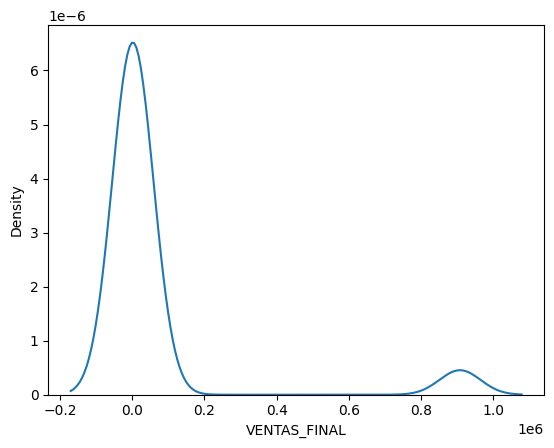

In [90]:
sns.kdeplot(modelo_ventas['VENTAS_FINAL'])

In [91]:
ventas_mas_500=[]
for i in modelo_ventas['VENTAS_FINAL']:
  if i >= 500:
    ventas_mas_500.append(i)
print('Nº startups con más de 500 mil € en ventas en el periodo final: ', len(ventas_mas_500), ' de un total de: ', len(modelo_ventas), ' empresas.')

Nº startups con más de 500 mil € en ventas en el periodo final:  332  de un total de:  927  empresas.


##Correlación con variable target

In [92]:
corr = modelo_ventas.corr(method='pearson')
corr[['VENTAS_FINAL']].sort_values(by = 'VENTAS_FINAL',ascending = False)\
.style.background_gradient()

<ipython-input-92-41afb2909a78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = modelo_ventas.corr(method='pearson')


,VENTAS_FINAL
VENTAS_FINAL,1.000000
C-V-ACREE_COM_CP_1,0.999956
A-1-VENTAS_2,0.999941
B-III-DEU_COM_1,0.999926
A-1-VENTAS_1,0.999917
A-1-VENTAS_3,0.999884
C-III-DEU_CP_1,0.999828
A-IV-INV_GRU_1,0.999743
A-PN-1_FP_1,0.999692
A-14-ING_FIN_1,0.999675


##Preparación de los datos

In [93]:
modelo2=pd.get_dummies(modelo_ventas)

In [94]:
cols = list(modelo2.columns)
cols.remove("VENTAS_FINAL") 
X = modelo2[cols].values
# Variable a predecir: 
Y = modelo2['VENTAS_FINAL']

In [95]:
# Check for infinite values
print(np.isfinite(X).all())

False


In [96]:
X = np.nan_to_num(X, nan=0, posinf=1e9, neginf=-1e9)

In [97]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

##Reducción de la dimensionalidad



En este bloque vamos a analizar si al aplicar una técnica de reducción de la dimensionalidad ayuda a mejorar la precisión del modelo.

**Métricas de regresión**
* Error medio cuadrado
* Error absoluto medio
* R2 Score

**Error Medio Cuadrado** (**MSE** por sus siglas en inglés):

El MSE se calcula como la media o el promedio de las diferencias al cuadrado entre los valores objetivo predichos y esperados en un conjunto de datos.
Cuanto mayor sea la diferencia entre los valores predichos y esperados, mayor será el error cuadrado positivo resultante.

**Error Absoluto Medio** (**MAE** por sus siglas en inglés):
MSE castiga más los errores grandes que los errores pequeños, inflando o magnificando la puntuación de error media. Esto se debe al cuadrado del valor de error. El MAE no da más o menos peso a los diferentes tipos de errores y, en cambio, las puntuaciones aumentan linealmente con los aumentos del error.

Como sugiere su nombre, la puntuación MAE se calcula como el promedio de los valores de error absoluto. 


**R2 Score**

R2 mide lo bien que un modelo de regresión se ajusta a los datos reales. En otras palabras, se trata de una medida de la precisión general del modelo. R al cuadrado es también conocido como el coeficiente de determinación.

R2 se mide en una escala de 0 a 1. Un valor de 1 indica un modelo que predice perfectamente los valores en el campo de destino. Un valor de 0 indica un modelo que no tiene ningún valor predictivo. 

###Modelo sin PCA con árbol de decisión

In [98]:
# Division of dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.15, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 42)

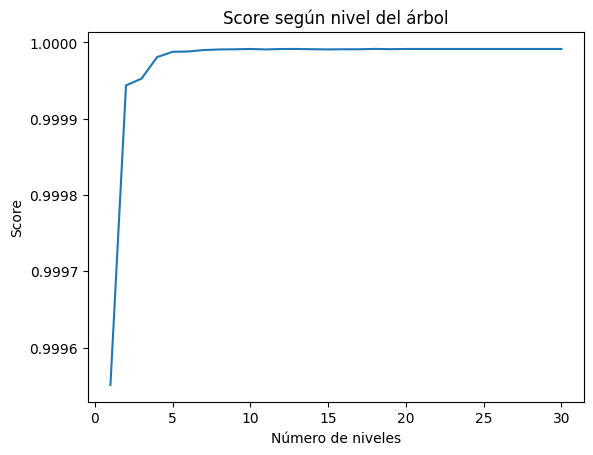

In [99]:
class_tree = tree.DecisionTreeRegressor(random_state=42)
scores = []
num_variables = len(X_scaled)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train, Y_train)
    scores.append(class_tree.score(X_test, Y_test))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()

In [100]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 17 niveles se obtuvo el mayor score


In [101]:
# Entrenamiento
reg_tree = tree.DecisionTreeRegressor(random_state=42,max_depth = 17)
reg_tree.fit(X_train, Y_train)

# Realizamos la predicción
Y_pred_test = reg_tree.predict(X_test)
y_pred_val=reg_tree.predict(X_val)

In [103]:
r2_score_test=r2_score(Y_test, Y_pred_test) # (coefficient of determination) regression score function. Best possible score is 1.0
mae_test=mean_absolute_error(Y_test, Y_pred_test) #Mean absolute error regression loss.
mse_test=mean_squared_error(Y_test, Y_pred_test) #Mean squared error regression loss.

r2_score_val=r2_score(Y_val, y_pred_val) 
mae_val=mean_absolute_error(Y_val, y_pred_val) 
mse_val=mean_squared_error(Y_val, y_pred_val) 

print('R2 Score Test: ', r2_score_test)
print('R2 Score Val: ', r2_score_val)
print('MAE Test: ', mae_test)
print('MAE Val: ', mae_val)
print('MSE Test: ', mse_test)
print('MSE Val: ', mse_val)

R2 Score Test:  0.9999911056438182
R2 Score Val:  0.9999714851421785
MAE Test:  86.69153061224489
MAE Val:  137.00569150737218
MSE Test:  485025.00572809536
MSE Val:  1472425.3790572449


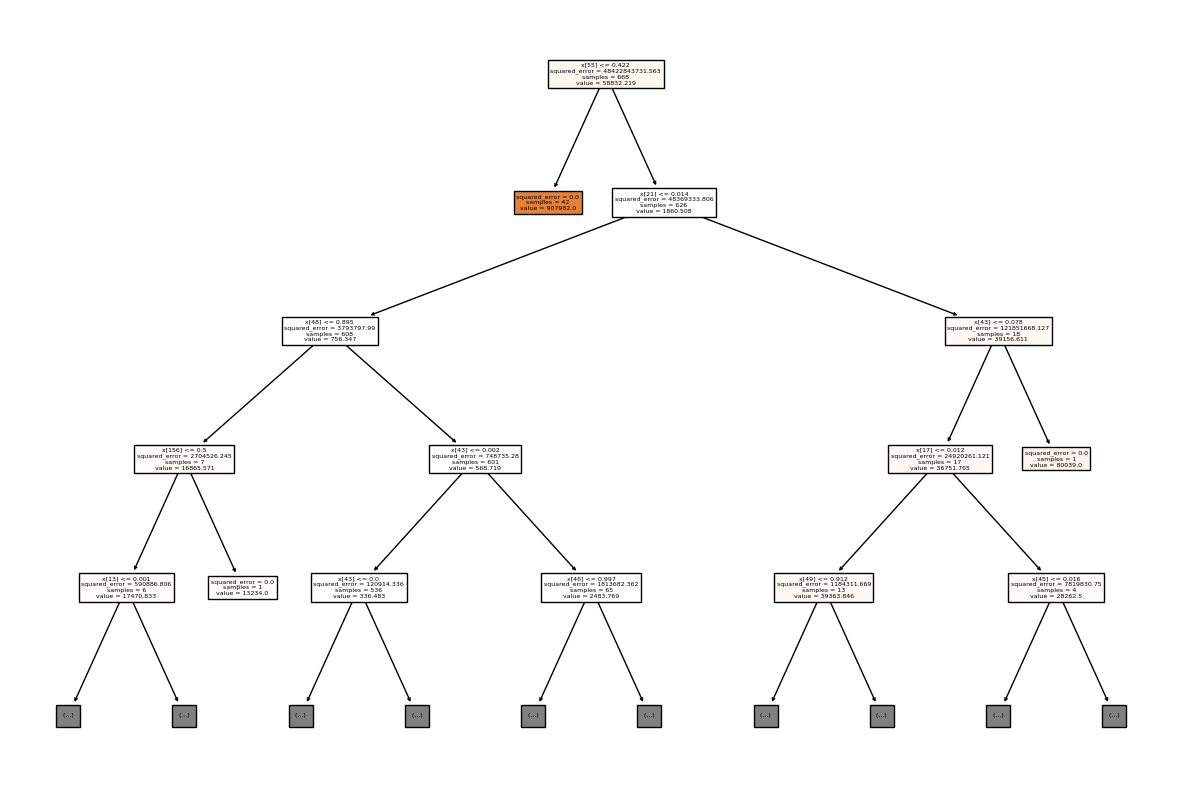

In [104]:
#Graficamente
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(reg_tree,filled=True, max_depth=4, class_names=cols)

###Con PCA

In [106]:
pca = PCA()
pca.fit(X_scaled)
eigenvalues = pca.explained_variance_

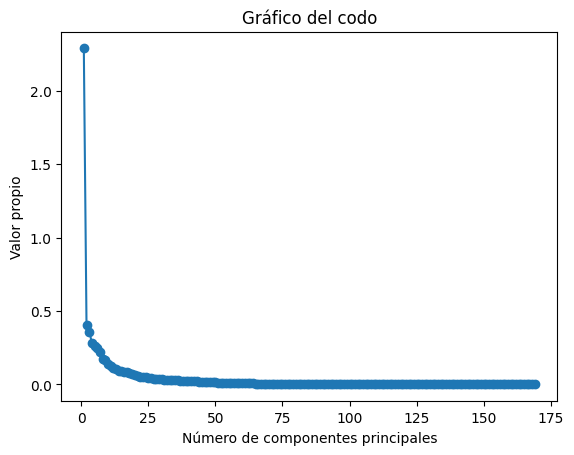

In [107]:
num_components = list(range(1, len(eigenvalues)+1))
plt.plot(num_components, eigenvalues, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Valor propio')
plt.title('Gráfico del codo')
plt.show()

In [108]:
idx = np.argmax(np.diff(eigenvalues))
num_components = idx + 1

print(f"El número óptimo de componentes principales es {num_components}")

El número óptimo de componentes principales es 144


In [118]:
pca = PCA(n_components=144)
pca_features = pca.fit_transform(X_scaled)

In [119]:
# Division of dataset
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(pca_features, Y, test_size = 0.15, random_state = 42)
X_train_pca, X_val_pca, Y_train_pca, Y_val_pca = train_test_split(X_train_pca, Y_train_pca, test_size = 0.15, random_state = 42)

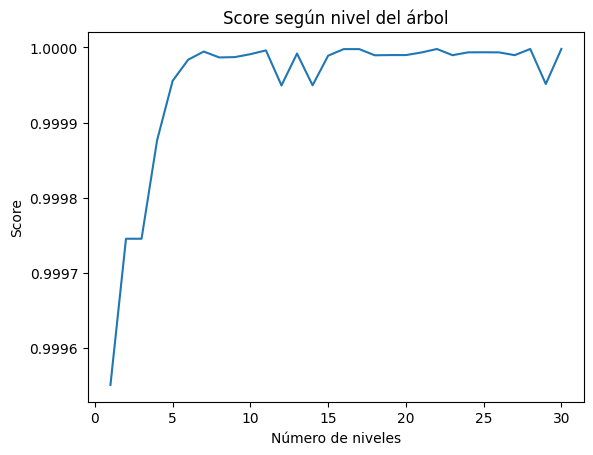

In [120]:
class_tree = tree.DecisionTreeRegressor(random_state=42)
scores = []
num_variables = len(pca_features)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train_pca, Y_train_pca)
    scores.append(class_tree.score(X_test_pca, Y_test_pca))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()

In [121]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 29 niveles se obtuvo el mayor score


In [122]:
# Entrenamiento
reg_tree2 = tree.DecisionTreeRegressor(random_state=42,max_depth = 29)
reg_tree2.fit(X_train_pca, Y_train_pca)

# Realizamos la predicción
Y_pred_test_pca = reg_tree2.predict(X_test_pca)
y_pred_val_pca=reg_tree2.predict(X_val_pca)

In [123]:
r2_score_test_pca=r2_score(Y_test_pca, Y_pred_test_pca) # (coefficient of determination) regression score function. Best possible score is 1.0
mae_test_pca=mean_absolute_error(Y_test_pca, Y_pred_test_pca) #Mean absolute error regression loss.
mse_test_pca=mean_squared_error(Y_test_pca, Y_pred_test_pca) #Mean squared error regression loss.

r2_score_val_pca=r2_score(Y_val_pca, y_pred_val_pca) 
mae_val_pca=mean_absolute_error(Y_val_pca, y_pred_val_pca) 
mse_val_pca=mean_squared_error(Y_val_pca, y_pred_val_pca) 

print('R2 Score Test: ', r2_score_test_pca)
print('R2 Score Val: ', r2_score_val_pca)
print('MAE Test: ', mae_test_pca)
print('MAE Val: ', mae_val_pca)
print('MSE Test: ', mse_test_pca)
print('MSE Val: ', mse_val_pca)

R2 Score Test:  0.9999512397640836
R2 Score Val:  0.9997335459773352
MAE Test:  219.2952380952381
MAE Val:  608.1876750700279
MSE Test:  2658982.080456349
MSE Val:  13758920.622315591


###Comparativa con PCA y sin PCA

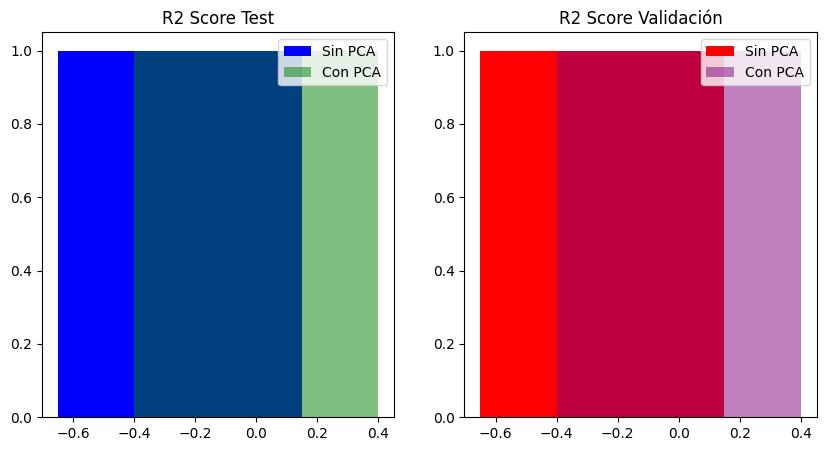

In [124]:
# Crear los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0].bar(x - width,r2_score_test, color='blue', label='Sin PCA')
axs[0].bar(x,r2_score_test_pca, color='green', alpha=0.5, label='Con PCA')
axs[0].set_title('R2 Score Test')
axs[0].legend()

axs[1].bar(x - width,r2_score_val, color='red', label='Sin PCA')
axs[1].bar(x,r2_score_val_pca, color='purple', alpha=0.5, label='Con PCA')
axs[1].set_title('R2 Score Validación')
axs[1].legend()

# Mostrar la gráfica
plt.show()

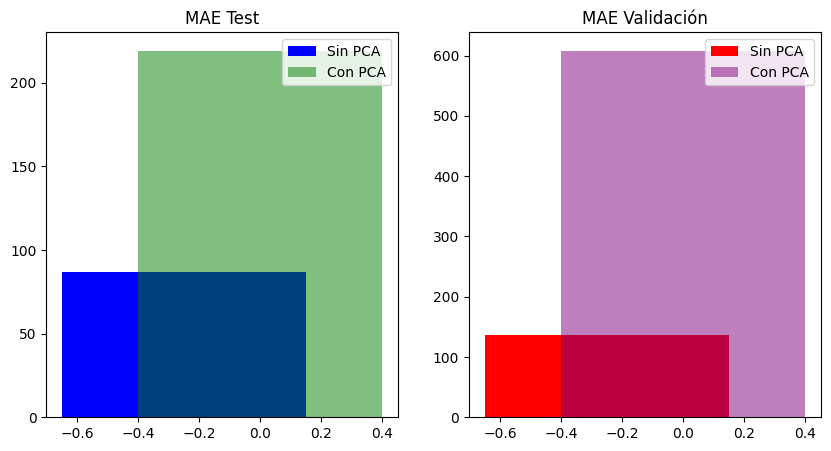

In [125]:
# Crear los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0].bar(x - width,mae_test, color='blue', label='Sin PCA')
axs[0].bar(x,mae_test_pca, color='green', alpha=0.5, label='Con PCA')
axs[0].set_title('MAE Test')
axs[0].legend()

axs[1].bar(x - width,mae_val, color='red', label='Sin PCA')
axs[1].bar(x,mae_val_pca, color='purple', alpha=0.5, label='Con PCA')
axs[1].set_title('MAE Validación')
axs[1].legend()

# Mostrar la gráfica
plt.show()

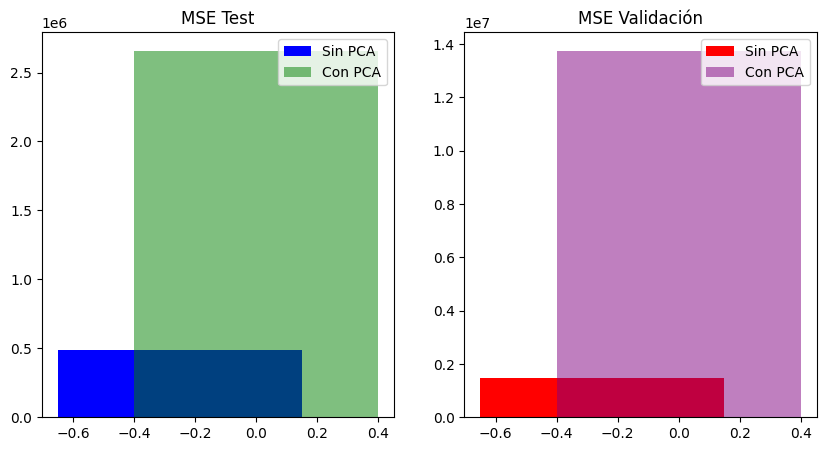

In [126]:
# Crear los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0].bar(x - width,mse_test, color='blue', label='Sin PCA')
axs[0].bar(x,mse_test_pca, color='green', alpha=0.5, label='Con PCA')
axs[0].set_title('MSE Test')
axs[0].legend()

axs[1].bar(x - width,mse_val, color='red', label='Sin PCA')
axs[1].bar(x,mse_val_pca, color='purple', alpha=0.5, label='Con PCA')
axs[1].set_title('MSE Validación')
axs[1].legend()

# Mostrar la gráfica
plt.show()

Como se puede observar, los resultados son mucho mejores sin la utilización de la PCA por lo que para el modelo de regresión no se va a realizar una reducción de la dimensionalidad. 

##Elección de modelo de ML

Por otro lado, dentro de los algoritmos de regresión tenemos:

**Caja Blanca**:
- Regresión lineal
- Árboles de decisión para regresión

**Caja Negra**:
- Máquinas de vector Soporte (SVM)
- Random Forest para regresión

Primero probamos con los algoritmos de caja blanca

El Árbol de decisión ya se ha probado antes al realizar la comparativa para ver si era mejor utilizar un algoritmo de reducción de la dimensionalidad. Ahora se va a probra la regresión lineal y se van a comparar los resultados.

###Regresión lineal

Búsqeuda de hiperparámetros

In [ ]:
model = LogisticRegression( max_iter=1000)



grid={"C": [0.001, 0.01, 0.1, 1, 10, 100], "solver":["sag", "saga"]}

grid_search = GridSearchCV(estimator = model,  
                           param_grid = grid,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, Y_train) 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter wa

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['sag', 'saga']},
             scoring='accuracy')

In [ ]:
# Mostrar los mejores hiperparámetros encontrados
print('Mejores hiperparámetros encontrados:\n', grid_search.best_params_)
print('Puntaje de precisión: {:.2f}'.format(grid_search.best_score_))

Mejores hiperparámetros encontrados:
 {'C': 10, 'solver': 'sag'}
Puntaje de precisión: 0.79


In [127]:
log_reg = LogisticRegression(solver='sag', C=10, max_iter=1000)

#Entreno el modelo
log_reg.fit(X_train, Y_train)

#Predicción para evaluación
y_pred_test=log_reg.predict(X_test)
y_pred_val=log_reg.predict(X_val)

In [128]:
r2_score_test_log=r2_score(Y_test, y_pred_test) # (coefficient of determination) regression score function. Best possible score is 1.0
mae_test_log=mean_absolute_error(Y_test, y_pred_test) #Mean absolute error regression loss.
mse_test_log=mean_squared_error(Y_test, y_pred_test) #Mean squared error regression loss.

r2_score_val_log=r2_score(Y_val, y_pred_val) 
mae_val_log=mean_absolute_error(Y_val, y_pred_val) 
mse_val_log=mean_squared_error(Y_val, y_pred_val) 

print('R2 Score Test: ', r2_score_test_log)
print('R2 Score Val: ', r2_score_val_log)
print('MAE Test: ', mae_test_log)
print('MAE Val: ', mae_val_log)
print('MSE Test: ', mse_test_log)
print('MSE Val: ', mse_val_log)

R2 Score Test:  0.9999840670667821
R2 Score Val:  0.999950764162368
MAE Test:  123.62857142857143
MAE Val:  207.2941176470588
MSE Test:  868851.0857142857
MSE Val:  2542397.277310924


###Comparativa de resultados entre el árbol de regresión y la regresión logística


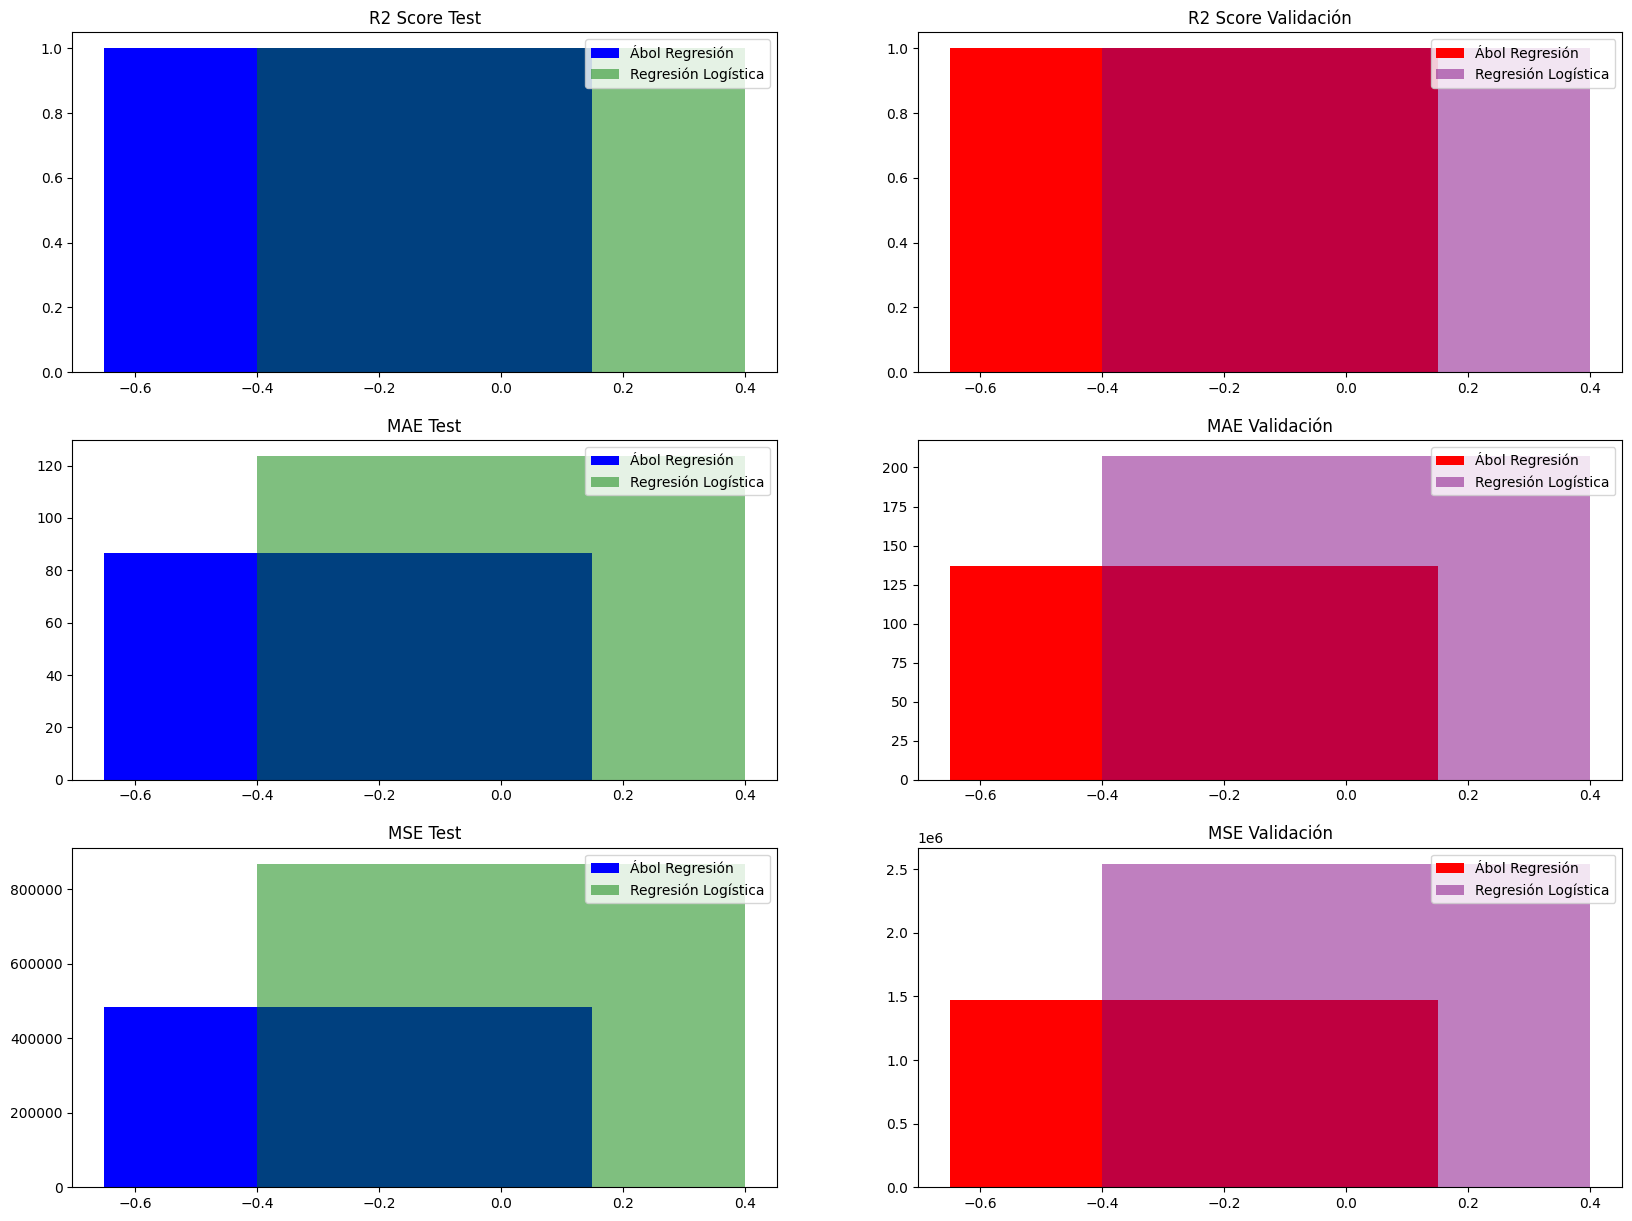

In [129]:
# Crear los subplots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0,0].bar(x - width,r2_score_test, color='blue', label='Ábol Regresión')
axs[0,0].bar(x,r2_score_test_log, color='green', alpha=0.5, label='Regresión Logística')
axs[0,0].set_title('R2 Score Test')
axs[0,0].legend()

axs[0,1].bar(x - width,r2_score_val, color='red', label='Ábol Regresión')
axs[0,1].bar(x,r2_score_val_log, color='purple', alpha=0.5, label='Regresión Logística')
axs[0,1].set_title('R2 Score Validación')
axs[0,1].legend()

# Graficar las variables en las gráficas correspondientes
axs[1,0].bar(x - width,mae_test, color='blue', label='Ábol Regresión')
axs[1,0].bar(x,mae_test_log, color='green', alpha=0.5, label='Regresión Logística')
axs[1,0].set_title('MAE Test')
axs[1,0].legend()

axs[1,1].bar(x - width,mae_val, color='red', label='Ábol Regresión')
axs[1,1].bar(x,mae_val_log, color='purple', alpha=0.5, label='Regresión Logística')
axs[1,1].set_title('MAE Validación')
axs[1,1].legend()

# Graficar las variables en las gráficas correspondientes
axs[2,0].bar(x - width,mse_test, color='blue', label='Ábol Regresión')
axs[2,0].bar(x,mse_test_log, color='green', alpha=0.5, label='Regresión Logística')
axs[2,0].set_title('MSE Test')
axs[2,0].legend()

axs[2,1].bar(x - width,mse_val, color='red', label='Ábol Regresión')
axs[2,1].bar(x,mse_val_log, color='purple', alpha=0.5, label='Regresión Logística')
axs[2,1].set_title('MSE Validación')
axs[2,1].legend()

# Mostrar la gráfica
plt.show()

Los resultados son mejores con el árbol de regresión, por lo que se va a utilizar dicho modelo. 

##Datos Nunca vistos

In [131]:
no_modelo_ventas=data[data['MODELO_CALCU']==0]

In [132]:
id=no_modelo_ventas['ID']
no_modelo_ventas.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'ALTO_CRECIMIENTO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'Unnamed: 0', 'ORGANISMO' ], axis=1, inplace=True)

<ipython-input-132-85ed9dd2d82f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_modelo_ventas.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'ALTO_CRECIMIENTO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'Unnamed: 0', 'ORGANISMO' ], axis=1, inplace=True)


In [133]:
no_modelo2=pd.get_dummies(no_modelo_ventas)

Vemos que haya el mismo número de features que en los datos del modelo

In [134]:
cols1=list(modelo2.columns)
cols2=list(no_modelo2.columns)
print(len(cols1), len(cols2))

170 170


Separamos los datos de la variable target

In [136]:
cols = list(no_modelo2.columns)
cols.remove("VENTAS_FINAL") 
X = no_modelo2[cols].values


In [78]:
# Check for infinite values
print(np.isfinite(X).all())

False


In [137]:
X = np.nan_to_num(X, nan=0, posinf=1e9, neginf=-1e9)

In [138]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Predecimos las ventas utilizando el modelo de regresión seleccionado

In [139]:
y_pred=reg_tree.predict(X_scaled)

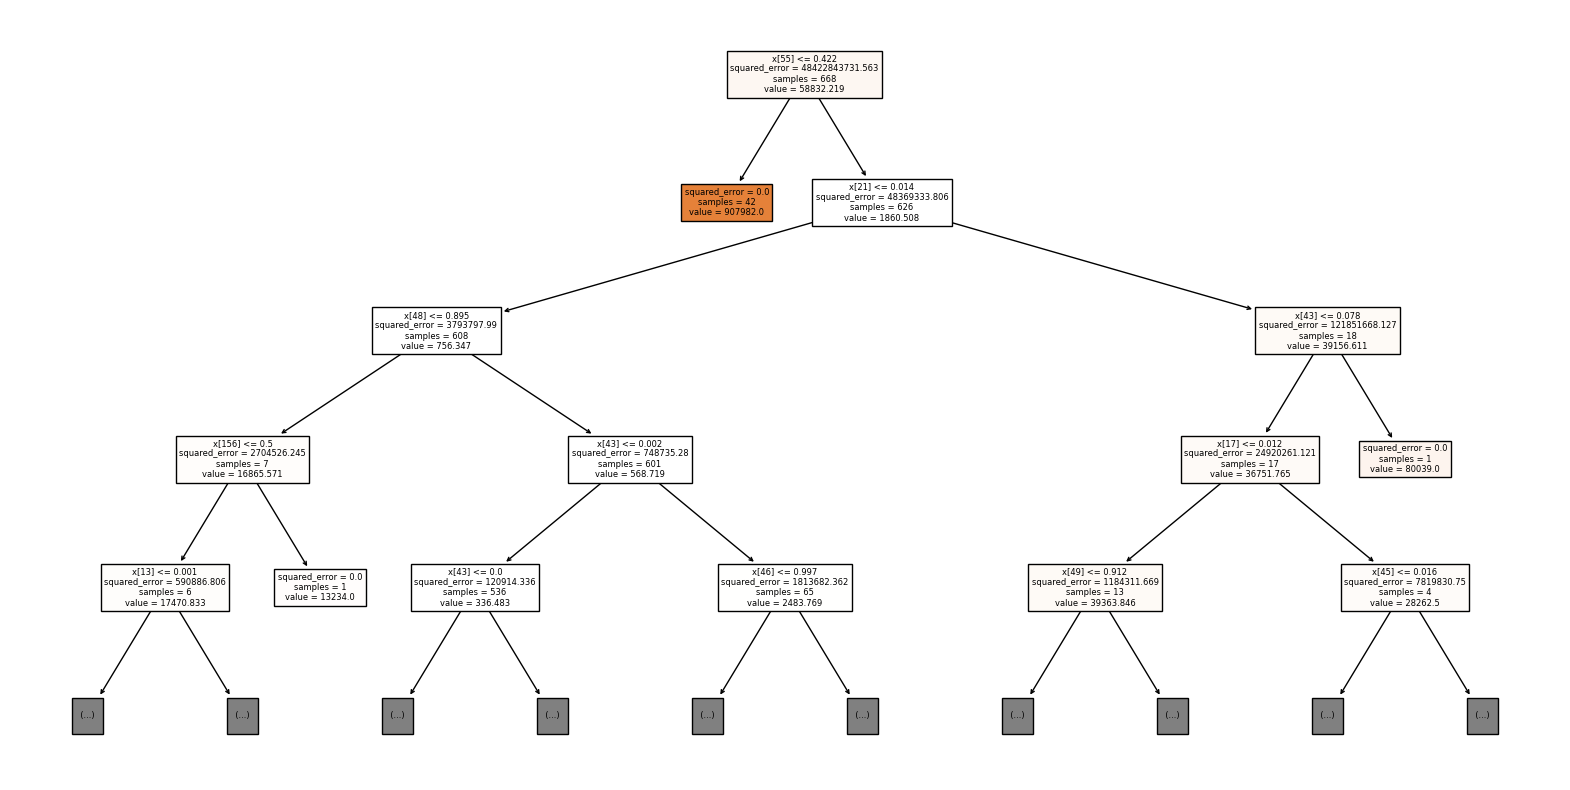

In [140]:
#Graficamente
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(reg_tree,filled=True, max_depth=4, class_names=cols)

In [141]:
no_modelo_ventas.drop(['VENTAS_FINAL'], axis=1, inplace=True)
no_modelo_ventas['VENTAS_PRED']=y_pred
no_modelo_ventas['ID']=id
no_modelo_ventas.to_csv('no_modelo_ventas.csv')

<ipython-input-141-bf377d69c847>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_modelo_ventas.drop(['VENTAS_FINAL'], axis=1, inplace=True)
<ipython-input-141-bf377d69c847>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_modelo_ventas['VENTAS_PRED']=y_pred
<ipython-input-141-bf377d69c847>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [142]:
ventas_mas_500=[]
for i in no_modelo_ventas['VENTAS_PRED']:
  if i >= 500:
    ventas_mas_500.append(i)
print('Nº startups con más de 500 mil € en ventas en el periodo final: ', len(ventas_mas_500), ' de un total de: ', len(no_modelo_ventas), ' empresas.')

Nº startups con más de 500 mil € en ventas en el periodo final:  1144  de un total de:  1236  empresas.


<Axes: xlabel='VENTAS_PRED', ylabel='Density'>

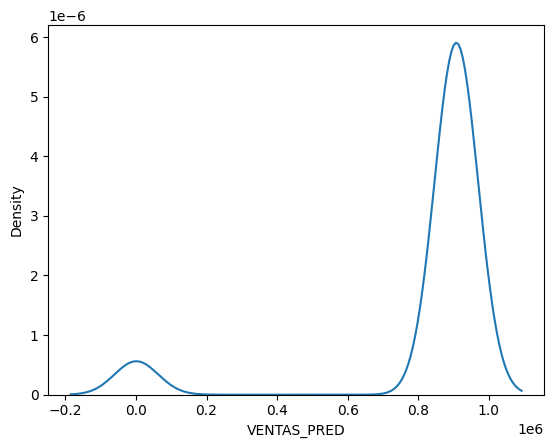

In [143]:
sns.kdeplot(no_modelo_ventas['VENTAS_PRED'])